# Finetuning SDXL DreamBooth using AutoTrain
Introduction to Generative AI Workshop

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/SkillSurf/introduction_genAI/blob/main/notebooks/S2/Session_2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

<br />
<br />

© SkillSurf 2024

# Part 1 - Training the pre-trained model

This notebook was created using the reference notebook published by [HuggingFace](https://colab.research.google.com/github/huggingface/autotrain-advanced/blob/main/colabs/AutoTrain_Dreambooth.ipynb).
- **Step 1** - Upload images to a folder named `images/`
- **Step 2** - Choose a project name (optional)
- **Step 3** - Update the prompt with a unique identifier (Choose a word that doesn't appear in dictionaries)
- **Step 4** - Run all cells in order until training is complete

For original notebook/code visit:https://github.com/huggingface/autotrain-advanced

## Installing AutoTrain

For training through Google Colab we will need the CLI version of AutoTrain installed as a Python package. Use pip to download and install the necessary dependancies and packages to the working environment.

In [ ]:
# Install AutoTrain using pip
import os
!pip install -U autotrain-advanced

## Setting up a training session

The following parameters are fed into the AutoTrain CLI command as hyper-parameters needed for model training. Select `stabilityai/stable-diffusion-xl-base-1.0` as the model name and continue with these defualt settings.

Feel free to experiment with the learning rate and epochs.


```{warning}
Remember to use a Unique identifier in the prompt. This identifier can be any token not commonly found in a dictionary.
```


In [2]:
# Basic details
project_name = 'dogexample'
model_name = 'stabilityai/stable-diffusion-xl-base-1.0'
prompt = 'a photo of a sks dog'

# Hyper-parameters
learning_rate = 1e-4
num_steps = 500
batch_size = 1
gradient_accumulation = 4
resolution = 1024
use_8bit_adam = False
use_xformers = False
mixed_precision = "fp16"
train_text_encoder = False
disable_gradient_checkpointing = False

# Set up environment variables
os.environ["PROJECT_NAME"] = project_name
os.environ["MODEL_NAME"] = model_name
os.environ["PROMPT"] = prompt
os.environ["LEARNING_RATE"] = str(learning_rate)
os.environ["NUM_STEPS"] = str(num_steps)
os.environ["BATCH_SIZE"] = str(batch_size)
os.environ["GRADIENT_ACCUMULATION"] = str(gradient_accumulation)
os.environ["RESOLUTION"] = str(resolution)
os.environ["USE_8BIT_ADAM"] = str(use_8bit_adam)
os.environ["USE_XFORMERS"] = str(use_xformers)
os.environ["MIXED_PRECISION"] = str(mixed_precision)
os.environ["TRAIN_TEXT_ENCODER"] = str(train_text_encoder)
os.environ["DISABLE_GRADIENT_CHECKPOINTING"] = str(disable_gradient_checkpointing)

Sometimes Colab can create unnecessary files which can throw erros when training. Run the following code to delete such files.

In [ ]:
# Run this cell to avoid errors
!rmdir /content/images/.ipynb_checkpoints

The code below runs a CLI command with the variables set-up above. Running this will start training the model.

In [ ]:
# Run the AutoTrain CLI command using parameteres given above
!autotrain dreambooth \
--model ${MODEL_NAME} \
--project-name ${PROJECT_NAME} \
--image-path images/ \
--prompt "${PROMPT}" \
--resolution ${RESOLUTION} \
--batch-size ${BATCH_SIZE} \
--num-steps ${NUM_STEPS} \
--gradient-accumulation ${GRADIENT_ACCUMULATION} \
--lr ${LEARNING_RATE} \
--mixed-precision ${MIXED_PRECISION} \
$( [[ "$USE_XFORMERS" == "True" ]] && echo "--xformers" ) \
$( [[ "$TRAIN_TEXT_ENCODER" == "True" ]] && echo "--train-text-encoder" ) \
$( [[ "$USE_8BIT_ADAM" == "True" ]] && echo "--use-8bit-adam" ) \
$( [[ "$DISABLE_GRADIENT_CHECKPOINTING" == "True" ]] && echo "--disable_gradient-checkpointing" )

## Save model weights to Google Drive

Now that we have trained the model for a long time, we don't want to lose the weights when we close the browser. So we can either download the folder with the `project name` from the file browser in Colab or we can save it to our Google Drive using the code below.

In [ ]:
# Mount Google Drive onto Colab Folder
from google.colab import drive
drive.mount('/content/drive')

In [10]:
# Copy session folder into a folder in the drive
!cp -r /content/dogexample /content/drive/MyDrive/Dreambooth/dogexample

# Part 2 - Generating images

Now that we have trained a large model, our resources have been occupied. We should free the occupied RAM and GPU RAM before generating images. To do that, restart the runtime session and proceed with the cells below.

## Importing modules and building the Stable Diffusion pipeline

We have the model weights in our project folder. They are saved as `pytorch_lora_weights.safetensors`. Now we will use Diffusers Python package to do the inferencing.

In [ ]:
# Import the diffusion pipeline and PyTorch
from diffusers import DiffusionPipeline
import torch

# Set up model details (Enter the path of your project folder)
prj_path = "/content/dogexample"
model = "stabilityai/stable-diffusion-xl-base-1.0"

# Create an instance of the pipeline
pipe = DiffusionPipeline.from_pretrained(
    model,
    torch_dtype=torch.float16,
)

# Send the pipeline to the GPU and load the finetuned weights
pipe.to("cuda")
pipe.load_lora_weights(prj_path, weight_name="pytorch_lora_weights.safetensors")

## Generating images for your own prompt

Finally, it's time to test out the finetuned model with our own prompts.

In [ ]:
# Write your own script, make it longer to be more specific
prompt = """a cartoon of a sks dog as a Jedi holding a lightsaber, Star Wars, hyper detailed background, character concept, full body, dynamic pose, intricate,
            highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, square thumbnail, 4k, uhd,
            art by artgerm and greg rutkowski and alphonse mucha"""

# Create the image and save it
seed = 42
generator = torch.Generator("cuda").manual_seed(seed)
image = pipe(prompt=prompt, generator=generator).images[0]
image.save(f"generated_image.png")

You can view the generated image in the folder directory in the left of the Colab Workspace. Otherwise run the following code to plot it.

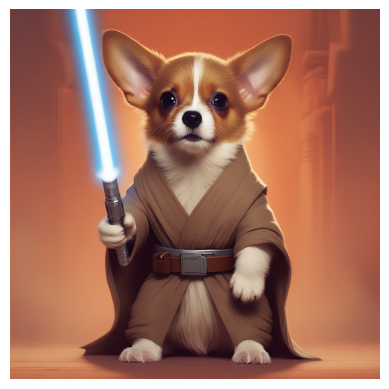

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
img = mpimg.imread("/content/generated_image.png")

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

You can clearly see that the model has now learned the features of our example dog and identifies him as a specific entity.

## (Optional) - Refining the generated images

Diffusers package comes with a built-in refiner. It can upscale the generated images increasing their quality. But due to the free resource limitation in Google Colab, using the generator pipeline and the refiner together will use up all the available RAM and GPU RAM. So the following code cannot be run on Google Colab free version.

However if you have purchased Colab computing units or have a good enough GPU on your local machine feel free to run this code.

In [ ]:
# Import refiner from Stable Diffusion
from diffusers import StableDiffusionXLImg2ImgPipeline

# Initialize refiner
refiner = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    torch_dtype=torch.float16,
)
refiner.to("cuda")

# Create new prompt
prompt = "cartoon of a sks dog riding a formula one race car, comic art, studio ghibli style"

# Generate new image
seed = 42
generator = torch.Generator("cuda").manual_seed(seed)
image = pipe(prompt=prompt, generator=generator).images[0]

# Refine the image
image = refiner(prompt=prompt, generator=generator, image=image).images[0]

image.save(f"refined_image.png")

# What next?

You can now finetune SDXL for your own images. Here's what you can try next.

- Use AutoTrain in HuggingFace Spaces
- Generate multiple images from one prompt
- Add negative prompt functionality

# References and Links

1. [AutoTrain Github Repository](https://github.com/huggingface/autotrain-advanced)
2. [How to train your own AI image models without breaking the bank](https://www.youtube.com/watch?v=9nniwr-7Em8&t=699s)
3. [Dreambooth Paper](https://dreambooth.github.io/)
4. [Hugging Face Spaces](https://huggingface.co/spaces)